## 0. Libarary 불러오기 및 경로설정

In [129]:
import os #os 제어 모듈 import 
import pandas as pd #pandas 라이브러리 import
from PIL import Image #Imgae 작업 기능 PIL라이브러리
#import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models #pre-trained model이나 dataset이 있다.
from torchvision.transforms import Resize, ToTensor, Normalize
#ToTensor는 torchvision라이브러리에 transforms 기능중 이미지 데이터 -> Tensor로 변환시키는 기능
#Normalize 는 torchvision라이브러리에 transforms 기능중 이미지 데이터의 픽셀 값을 정규화 시켜준다.
#Resize는 torchvision라이브러리에 transforms 기능중 이미지 크기 조절하는 기능이다.

from dataset import MaskBaseDataset, BaseAugmentation, MaskSplitByProfileDataset
import train as tr

# 1. Data Analysis
데이터에 대해서 이해하는 작업을 먼저 수행한다.(EDA)

In [91]:
test_dir = '/opt/ml/input/data/eval' #test데이터 경로
train_dir = '/opt/ml/input/data/train'
print(os.getcwd())

/opt/ml/code


In [92]:
#test관련 정보
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

#컬럼 정보
def column_info(dataframe):
    return dataframe.columns

#크기 파악하기
def shape(dataframe):
    return dataframe.shape

#정보 파악하기
def infomation(dataframe):
    return dataframe.info()

#print('[Test 데이터 파악하기]')
#print('컬럼명 확인하기 :', column_info(submission), '\n')
#print('(행 개수, 열 개수) : ', shape(submission), '\n')
#print('데이터 정보 \n', infomation(submission))



In [108]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_data_images = os.path.join(train_dir, 'images')

#컬럼 정보
def column_info(dataframe):
    return dataframe.columns

#크기 파악하기
def shape(dataframe):
    return dataframe.shape

#정보 파악하기
def infomation(dataframe):
    return dataframe.info()

# print('[Train 데이터 파악하기]')
# print('컬럼명 확인하기 :', column_info(train_csv), '\n')
# print('(행 개수, 열 개수) : ', shape(train_csv), '\n')
# print('데이터 정보 \n', infomation(train_csv))



# 2. DataLabeling

In [109]:
import os
import pandas as pd
import tqdm
import re

class Make_Label():
    def __init__(self, BASE_PATH, CSV_FILE, COLS):
        self.path= BASE_PATH
        self.img_path= os.path.join(self.path, 'images')
        self.csv_file= CSV_FILE
        self.df= pd.DataFrame(columns= COLS)

    def labeling(self):
        idx_df = 0
        for idx in tqdm.tqdm(range(train_csv.shape[0])):
            IMG_PATH = os.path.join(self.img_path, train_csv.iloc[idx]['path']) # image path
            file_list = os.listdir(IMG_PATH)

            for file in file_list:
                if file.rstrip().startswith('._'): # server 내에서 ._{파일명} 제거
                    continue
                
                file_path = os.path.join(IMG_PATH, file)
                self.df.loc[idx_df] = train_csv.loc[idx][['gender', 'age']] # train.csv 파일에서 gender, age 정보를 가져옴
                self.df.loc[idx_df]['path'] = file_path # image 전체 경로
                self.df.loc[idx_df]['name'] = file # image 파일 이름
                self.check_label(self.df, idx_df)
                idx_df += 1

        self.df.to_csv('train_with_label2.csv') # csv 파일 형식으로 저장

    def check_label(self, df, idx_df):
        # DataFrame의 mask, gender, age 정보를 가져옴 
        mask = df.loc[idx_df]['name'][:4] 
        gender = df.loc[idx_df]['gender'] 
        age = df.loc[idx_df]['age'] 

        # 데이터 tab의 class description 기준으로 분류
        if mask == 'mask':
            if gender == 'male':
                if age < 30:
                    df.loc[idx_df]['label'] = 0
                elif age < 60:
                    df.loc[idx_df]['label'] = 1
                else:
                    df.loc[idx_df]['label'] = 2
            else:
                if age < 30:
                    df.loc[idx_df]['label'] = 3
                elif age < 60:
                    df.loc[idx_df]['label'] = 4
                else:
                    df.loc[idx_df]['label'] = 5
        elif mask == 'inco':  # incorrct_mask
            if gender == 'male':
                if age < 30:
                    df.loc[idx_df]['label'] = 6
                elif age < 60:
                    df.loc[idx_df]['label'] = 7
                else:
                    df.loc[idx_df]['label'] = 8
            else:
                if age < 30:
                    df.loc[idx_df]['label'] = 9
                elif age < 60:
                    df.loc[idx_df]['label'] = 10
                else:
                    df.loc[idx_df]['label'] = 11
        elif mask == 'norm':  # not wear
            if gender == 'male':
                if age < 30:
                    df.loc[idx_df]['label'] = 12
                elif age < 60:
                    df.loc[idx_df]['label'] = 13
                else:
                    df.loc[idx_df]['label'] = 14
            else:
                if age < 30:
                    df.loc[idx_df]['label'] = 15
                elif age < 60:
                    df.loc[idx_df]['label'] = 16
                else:
                    df.loc[idx_df]['label'] = 17


if __name__== '__main__':

    BASE_TRAIN_PATH= train_dir
    train_csv= pd.read_csv(os.path.join(BASE_TRAIN_PATH, 'train.csv'))

    make_label= Make_Label(BASE_TRAIN_PATH, train_csv, ['gender', 'age', 'path', 'name', 'label'])
    make_label.labeling()

100%|██████████| 2700/2700 [01:33<00:00, 28.92it/s]


Populating the interactive namespace from numpy and matplotlib
/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg


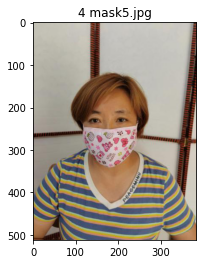

/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg


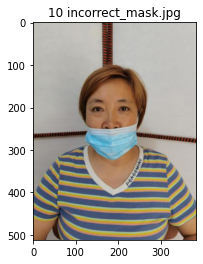

/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg


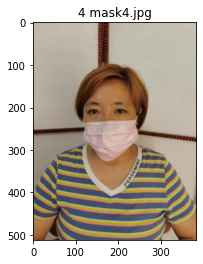

/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg


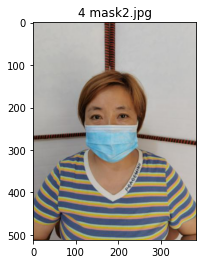

/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg


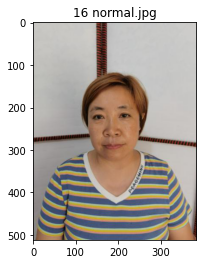

In [110]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for index, row in make_label.df.head().iterrows():
    label = row[4]
    print(row[2])
    img = mpimg.imread(row[2])
    imgplot = plt.imshow(img)
    plt.title(str(label) + ' ' + row[3])
    plt.show()

# 3. DataSet & DataSplit

### 3-1) Make DataSet
- using 'Dataset', Making Dataset

### 3-2) Split Dataset to Train and Valid
- using 'sklearn', train_test_split()

### 3-3) Nan(결측값) 제거
- using 'dropna' function


In [114]:
total_dataset = MaskBaseDataset(train_data_images)

inject_transform = BaseAugmentation(224,total_dataset.mean, total_dataset.std )

total_dataset.set_transform(inject_transform)

print(total_dataset[3])
print(total_dataset.calc_statistics)

(tensor([[[ 1.1129,  1.1129,  1.1129,  ..., -0.5583, -0.6245, -0.6741],
         [ 1.1129,  1.1129,  1.1129,  ..., -0.6576, -0.6907, -0.7238],
         [ 1.1129,  1.1129,  1.1129,  ..., -0.7734, -0.8230, -0.8561],
         ...,
         [-0.7072, -0.7238, -0.7734,  ..., -0.2770, -0.4921, -0.8065],
         [-0.5086, -0.4425, -0.4590,  ..., -1.0216, -1.0878, -1.1540],
         [-0.5748, -0.3928, -0.3928,  ..., -1.1540, -1.0878, -1.1043]],

        [[ 1.0714,  1.0714,  1.0714,  ...,  0.9761,  0.9285,  0.8967],
         [ 1.0714,  1.0714,  1.0714,  ...,  0.8808,  0.8650,  0.8491],
         [ 1.0714,  1.0714,  1.0714,  ...,  0.7856,  0.7538,  0.7221],
         ...,
         [-0.4846, -0.5004, -0.5481,  ..., -0.0876, -0.3099, -0.5957],
         [-0.2940, -0.2305, -0.2464,  ..., -0.8180, -0.8974, -0.9609],
         [-0.3575, -0.1829, -0.1829,  ..., -0.9926, -0.9291, -0.9450]],

        [[ 1.1455,  1.1455,  1.1455,  ...,  0.8745,  0.8266,  0.7948],
         [ 1.1455,  1.1455,  1.1455,  ...,  

In [40]:
# from torchvision import transforms, utils

# class MyDataset(Dataset):
#     def __init__(self, data_frame):
#         self.X = data_frame['path']
#         self.y = data_frame['label']
#         #print(self.X, self.y)
             
#     def __getitem__(self, idx):
#         X, y = None, None
#         im = Image.open(self.X.iloc[idx])
#         #im = transforms.CenterCrop((100,100))(im)
#         im = transforms.Resize((224,224))(im)
        
#         im = transforms.ToTensor()(im)
#         X = transforms.Normalize([0.5, 0.56, 0.5], [0.229, 0.224, 0.225])(im)
#         y = torch.tensor(self.y.iloc[idx], dtype=torch.long)
#         return X, y
    
#     def __len__(self):
#         return len(self.X)

In [41]:
# train_data = MyDataset(make_label.df)
#print('전체 데이터 길이 : ' + str(len((train_data))))
#print('첫번째 데이터 확인 : {}'.format(next(iter(train_data))))

In [42]:
#image, label = next(iter(train_data))
#pd.DataFrame(np.int32(image.numpy()[0]*700)).style.set_properties(**{'font-size':'2pt'}).background_gradient(axis=None)

In [122]:
split_object  = MaskSplitByProfileDataset(train_data_images)

inject_transform = BaseAugmentation(224,split_object.mean, split_object.std )
split_object.set_transform(inject_transform)
train_dataset , valid_dataset = split_object.split_dataset()

print(train_dataset[1], len(train_dataset))
print(valid_dataset[1], len(valid_dataset))

(tensor([[[ 1.3777,  1.2288,  1.5597,  ..., -0.5086, -0.5252, -0.5583],
         [ 1.3942,  1.2453,  1.5597,  ..., -0.4094, -0.4259, -0.4425],
         [ 1.4273,  1.2453,  1.5431,  ..., -0.3928, -0.3928, -0.4094],
         ...,
         [ 1.0302,  0.8316,  0.5834,  ..., -1.2036, -1.1540, -1.1043],
         [ 1.2619,  1.2453,  1.2122,  ..., -1.1705, -1.0878, -1.0712],
         [ 0.9475,  1.1129,  1.1957,  ..., -1.1540, -1.0547, -1.0547]],

        [[ 1.2619,  1.1190,  1.4365,  ...,  1.1349,  1.0714,  1.0396],
         [ 1.2778,  1.1349,  1.4365,  ...,  1.2143,  1.1666,  1.1349],
         [ 1.3095,  1.1349,  1.4207,  ...,  1.1984,  1.1825,  1.1666],
         ...,
         [ 1.1825,  0.9920,  0.7856,  ..., -0.9767, -0.9291, -0.8815],
         [ 1.3730,  1.3571,  1.3413,  ..., -0.9450, -0.8656, -0.8497],
         [ 1.0555,  1.1984,  1.2936,  ..., -0.9291, -0.8338, -0.8338]],

        [[ 1.3208,  1.1773,  1.4643,  ...,  0.9701,  0.9223,  0.8904],
         [ 1.3368,  1.1933,  1.4643,  ...,  

In [113]:
# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(train_data.X, train_data.y, test_size=0.3,shuffle=True)
# train_data_frame = pd.DataFrame({'path':x_train, 'label':y_train})
# valid_data_frame = pd.DataFrame({'path':x_valid, 'label':y_valid})
# print('결측치 제거 이전 train_dataframe 개수 : ' + str(len(train_data_frame)))
# print('결측치 제거 이전 valid_dataframe 개수 : ' + str(len(valid_data_frame)))
# train_data_frame = train_data_frame.dropna(axis=0)
# valid_data_frame = valid_data_frame.dropna(axis=0)

# #결측치 날려버림!
# print("================================================================")
# print('결측치 제거 이후 train_dataframe 개수 : ' + str(len(train_data_frame)))
# print('결측치 제거 이후 valid_dataframe 개수 : ' + str(len(valid_data_frame)))

# train_dataset = MyDataset(train_data_frame)
# valid_dataset = MyDataset(valid_data_frame)

# next(iter(train_dataset))
# print(valid_dataset[1])

# print(type(train_dataset))
# print(type(valid_dataset))

# 4. DataLoader
- DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [44]:
train_loader = torch.utils.data.DataLoader(
	train_dataset,
    batch_size = 32,
    drop_last = True,
)
valid_loader = torch.utils.data.DataLoader(
	valid_dataset,
    batch_size = 32,
    drop_last = True,
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloders = {'train' : train_loader, 'val' : valid_loader}
dataset_sizes = {'train' : len(train_loader), 'val' : len(valid_loader)}

# 5. Test Dataset 정의

In [45]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## (skip)Train image 가져오기
- 너무 오래걸려서 위에 것으로 수정

In [46]:
# import PIL.Image as pilimg
# import numpy as np
# import cv2

# def labeling(mask, gender, age):
#     if mask in ['mask1', 'mask2', 'mask3', 'mask4', 'mask5']:
#         mask = 'mask'
    
#     if mask == 'mask':
#         if gender == 'male':
#             if age < 30:
#                 return 0
#             elif 30 <= age < 60:
#                 return 1
#             elif age >= 60:
#                 return 2
#         elif gender == 'female':
#             if age < 30:
#                 return 3
#             elif 30 <= age < 60:
#                 return 4
#             elif age >= 60:
#                 return 5
#     elif mask == 'incorrect_mask':
#         if gender == 'male':
#             if age < 30:
#                 return 6
#             elif 30 <= age < 60:
#                 return 7
#             elif age >= 60:
#                 return 8
#         elif gender == 'female':
#             if age < 30:
#                 return 9
#             elif 30 <= age < 60:
#                 return 10
#             elif age >= 60:
#                 return 11
#     elif mask == 'normal':
#         if gender == 'male':
#             if age < 30:
#                 return 12
#             elif 30 <= age < 60:
#                 return 13
#             elif age >= 60:
#                 return 14
#         elif gender == 'female':
#             if age < 30:
#                 return 15
#             elif 30 <= age < 60:
#                 return 16
#             elif age >= 60:
#                 return 17
    
# def data_load(path, data_path):
#     tensor_list = []
#     for one_path in zip(path.loc[:,'path'], path.loc[:,'gender'], path.loc[:,'age']):
#         one_person_dir = data_path + '/' + one_path[0]
#         for one_image in os.listdir(one_person_dir):
#             if one_image[0] == '.':
#                 continue
#             else:
#                 label = labeling(os.path.splitext(one_image)[0], one_path[1], one_path[2])
#                 im = Image.open(one_person_dir + '/' + one_image)
#                 image = ToTensor()(im)
#                 tensor_list.append((image,label))
#     return tensor_list
                
# train_data = data_load(train_csv, train_data)

# 6. Model 정의

In [53]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #print(loss.item(), inputs.size(1))
                #print("------------------------------")
                #print(preds, labels.data)
                
                # statistics
                running_loss += loss.item() * inputs.size(1)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'val':
                scheduler.step(running_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss / 32, epoch_acc / 32))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 32, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc // 32))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 7. Training


In [136]:
!python train.py
#print(tr.train(train_data_images, os.path.join(os.getcwd(), 'model.py')))

Namespace(augmentation='BaseAugmentation', batch_size=64, criterion='cross_entropy', data_dir='/opt/ml/input/data/train/images', dataset='MaskBaseDataset', epochs=1, log_interval=20, lr=0.001, lr_decay_step=20, model='BaseModel', model_dir='./model', name='exp', optimizer='SGD', resize=[128, 96], seed=42, val_ratio=0.2, valid_batch_size=1000)
--------
/opt/ml/input/data/train/images ./model
--------
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, p

In [54]:
import torch.optim as optim
from torch.optim import lr_scheduler

print(models)
model_conv = models.resnext50_32x4d(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
#print(model_conv)

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 18)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_conv,  'min')

<module 'torchvision.models' from '/opt/conda/lib/python3.8/site-packages/torchvision/models/__init__.py'>


In [55]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,25)

Epoch 0/24
----------
train Loss: 0.1035 Acc: 0.6632
val Loss: 0.0693 Acc: 0.7648
Epoch 1/24
----------
train Loss: 0.0654 Acc: 0.7721
val Loss: 0.0612 Acc: 0.7841
Epoch 2/24
----------
train Loss: 0.0568 Acc: 0.7960
val Loss: 0.0582 Acc: 0.7934
Epoch 3/24
----------
train Loss: 0.0517 Acc: 0.8153
val Loss: 0.0569 Acc: 0.7971
Epoch 4/24
----------
train Loss: 0.0479 Acc: 0.8291
val Loss: 0.0561 Acc: 0.8014
Epoch 5/24
----------
train Loss: 0.0450 Acc: 0.8395
val Loss: 0.0555 Acc: 0.8033
Epoch 6/24
----------
train Loss: 0.0425 Acc: 0.8511
val Loss: 0.0552 Acc: 0.8047
Epoch 7/24
----------
train Loss: 0.0404 Acc: 0.8599
val Loss: 0.0550 Acc: 0.8053
Epoch 8/24
----------
train Loss: 0.0385 Acc: 0.8686
val Loss: 0.0549 Acc: 0.8069
Epoch 9/24
----------
train Loss: 0.0369 Acc: 0.8758
val Loss: 0.0550 Acc: 0.8095
Epoch 10/24
----------
train Loss: 0.0354 Acc: 0.8815
val Loss: 0.0551 Acc: 0.8109
Epoch 11/24
----------
train Loss: 0.0340 Acc: 0.8859
val Loss: 0.0552 Acc: 0.8104
Epoch 12/24
--

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


## 7-1. Custom Model 만들기

In [ ]:
class AgeGenderModel(nn.Module):
    def __init__(self, encoder, encoder_channels, age_classes, gender_classes, output_channels=512):
        super().__init__()

        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits, gender_logits

# 8. Inference

In [56]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    #transforms.CenterCrop((100,100)),
    Resize((224, 224)),
    ToTensor(),
    transforms.Normalize([0.5, 0.56, 0.5], [0.229, 0.224, 0.225])
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle = False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model_ft.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission1.csv'), index=False)
print('test inference is done!')

test inference is done!
